# Modelo No Supervisado para An√°lisis de Patrones de Estr√©s

PROYECTO: Sistema Inteligente de Predicci√≥n Temprana de Enfermedades Cr√≥nicas
MODELO: An√°lisis No Supervisado de Patrones de Estr√©s
OBJETIVO: Identificar grupos naturales de pacientes seg√∫n sus niveles y patrones de estr√©s

T√©cnicas utilizadas:
- K-Means Clustering
- Hierarchical Clustering
- DBSCAN
- An√°lisis de Componentes Principales (PCA)

Variables para an√°lisis de estr√©s:
- Nivel_estres (variable principal)
- Frecuencia_cardiaca (indicador fisiol√≥gico de estr√©s)
- Presion_sistolica (respuesta cardiovascular al estr√©s)
- Variabilidad_ritmo (sistema nervioso aut√≥nomo)
- Temperatura (respuesta termorregulatoria)

### 1. IMPORTACI√ìN DE LIBRER√çAS

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Configuraci√≥n de visualizaci√≥n
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

### 2. CARGA Y PREPARACI√ìN DE DATOS

In [11]:
print("CARGA Y PREPARACI√ìN DE DATOS PARA AN√ÅLISIS DE ESTR√âS")
print("="*60)

# Cargar el dataset limpio
try:
    df = pd.read_csv('../preprocessing/data/processed/mediciones_cardiacas_clean.csv')
    print("‚úÖ Dataset cargado exitosamente")
    print(f" Dimensiones del dataset: {df.shape}")
except FileNotFoundError:
    print("‚ùå Error: No se encontr√≥ el archivo 'mediciones_cardiacas_limpio.csv'")



CARGA Y PREPARACI√ìN DE DATOS PARA AN√ÅLISIS DE ESTR√âS
‚úÖ Dataset cargado exitosamente
 Dimensiones del dataset: (6587, 11)


In [15]:
# Variables relacionadas con el estr√©s
# El estr√©s afecta m√∫ltiples sistemas fisiol√≥gicos
variables_estres = [
    'Nivel_estres',          # Variable principal de estr√©s
    'Frecuencia_cardiaca',   # El estr√©s aumenta la FC
    'Presion_sistolica',     # El estr√©s eleva la presi√≥n arterial
    'Variabilidad_ritmo',    # El estr√©s reduce la variabilidad card√≠aca
    'Temperatura'            # El estr√©s puede afectar la temperatura corporal
]

print(f"\n Variables seleccionadas para an√°lisis de estr√©s:")
for i, var in enumerate(variables_estres, 1):
    print(f"   {i}. {var}")

# Filtrar datos para an√°lisis
df_estres = df[variables_estres].copy()

print(f"\n Dataset para an√°lisis de estr√©s:")
print(f"   ‚Ä¢ Muestras: {len(df_estres)}")
print(f"   ‚Ä¢ Variables: {len(variables_estres)}")

# Verificar datos faltantes
print(f"\n Valores faltantes por variable:")
for var in variables_estres:
    missing = df_estres[var].isnull().sum()
    print(f"   ‚Ä¢ {var}: {missing} ({missing/len(df_estres)*100:.1f}%)")



 Variables seleccionadas para an√°lisis de estr√©s:
   1. Nivel_estres
   2. Frecuencia_cardiaca
   3. Presion_sistolica
   4. Variabilidad_ritmo
   5. Temperatura

 Dataset para an√°lisis de estr√©s:
   ‚Ä¢ Muestras: 6587
   ‚Ä¢ Variables: 5

 Valores faltantes por variable:
   ‚Ä¢ Nivel_estres: 0 (0.0%)
   ‚Ä¢ Frecuencia_cardiaca: 0 (0.0%)
   ‚Ä¢ Presion_sistolica: 0 (0.0%)
   ‚Ä¢ Variabilidad_ritmo: 0 (0.0%)
   ‚Ä¢ Temperatura: 0 (0.0%)


In [17]:
# Estad√≠sticas descriptivas b√°sicas
print(f"\n Estad√≠sticas descriptivas:")
print(df_estres.describe().round(2))


 Estad√≠sticas descriptivas:
       Nivel_estres  Frecuencia_cardiaca  Presion_sistolica  \
count       6587.00              6587.00            6587.00   
mean           7.09                69.00             111.80   
std            2.32                14.62              14.87   
min            0.00                45.00              82.00   
25%            5.00                58.00             101.00   
50%            7.00                66.00             110.00   
75%            9.00                78.00             120.00   
max           10.00               123.00             185.00   

       Variabilidad_ritmo  Temperatura  
count             6587.00      6587.00  
mean                33.87        36.51  
std                 10.48         0.50  
min                  6.22        35.20  
25%                 26.25        36.10  
50%                 33.00        36.50  
75%                 41.07        36.80  
max                 77.79        38.10  


### 3. AN√ÅLISIS EXPLORATORIO ESPEC√çFICO PARA ESTR√âS

AN√ÅLISIS EXPLORATORIO - PATRONES DE ESTR√âS


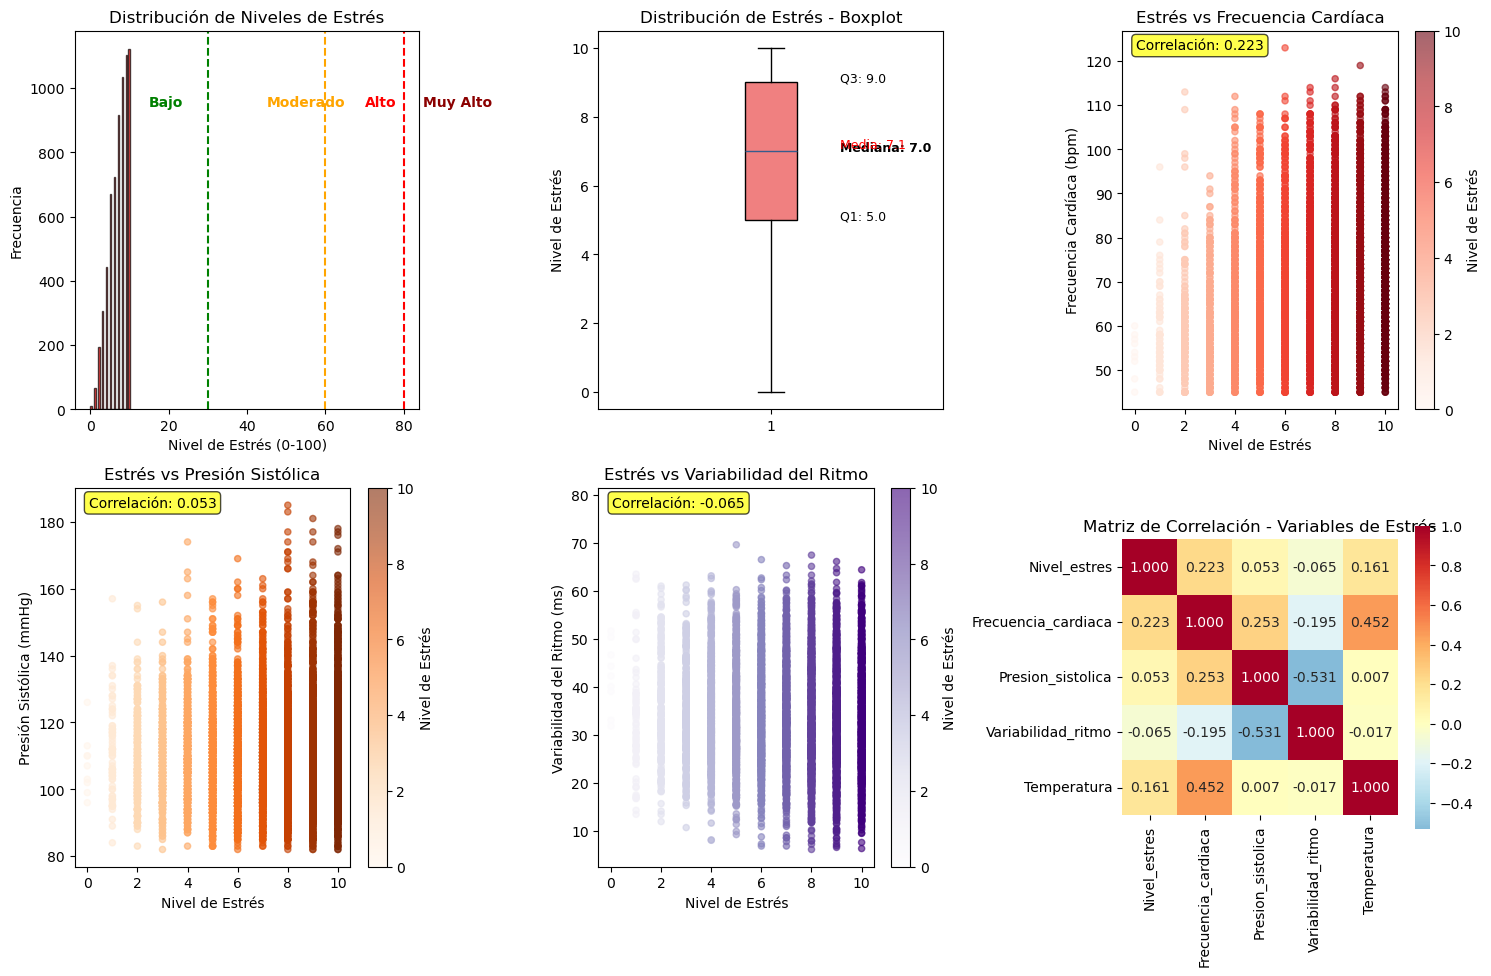


 An√°lisis de correlaciones con el nivel de estr√©s:
   ‚Ä¢ Frecuencia_cardiaca: 0.223 (Correlaci√≥n d√©bil)
   ‚Ä¢ Presion_sistolica: 0.053 (Correlaci√≥n muy d√©bil)
   ‚Ä¢ Variabilidad_ritmo: -0.065 (Correlaci√≥n muy d√©bil)
   ‚Ä¢ Temperatura: 0.161 (Correlaci√≥n muy d√©bil)


In [22]:
print("AN√ÅLISIS EXPLORATORIO - PATRONES DE ESTR√âS")
print("="*60)

# Gr√°fico 1: Distribuci√≥n de niveles de estr√©s
plt.figure(figsize=(15, 10))

# Subplot 1: Histograma de nivel de estr√©s
plt.subplot(2, 3, 1)
plt.hist(df_estres['Nivel_estres'], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Distribuci√≥n de Niveles de Estr√©s')
plt.xlabel('Nivel de Estr√©s (0-100)')
plt.ylabel('Frecuencia')

# Agregar l√≠neas de referencia para niveles de estr√©s
plt.axvline(30, color='green', linestyle='--', label='Bajo (0-30)')
plt.axvline(60, color='orange', linestyle='--', label='Moderado (30-60)')
plt.axvline(80, color='red', linestyle='--', label='Alto (60-80)')
plt.text(15, plt.ylim()[1]*0.8, 'Bajo', color='green', fontweight='bold')
plt.text(45, plt.ylim()[1]*0.8, 'Moderado', color='orange', fontweight='bold')
plt.text(70, plt.ylim()[1]*0.8, 'Alto', color='red', fontweight='bold')
plt.text(85, plt.ylim()[1]*0.8, 'Muy Alto', color='darkred', fontweight='bold')

# Subplot 2: Boxplot de nivel de estr√©s
plt.subplot(2, 3, 2)
box_plot = plt.boxplot(df_estres['Nivel_estres'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightcoral')
plt.title('Distribuci√≥n de Estr√©s - Boxplot')
plt.ylabel('Nivel de Estr√©s')

# Calcular estad√≠sticas del estr√©s
q1 = df_estres['Nivel_estres'].quantile(0.25)
q2 = df_estres['Nivel_estres'].median()
q3 = df_estres['Nivel_estres'].quantile(0.75)
mean_stress = df_estres['Nivel_estres'].mean()

plt.text(1.2, q1, f'Q1: {q1:.1f}', fontsize=9)
plt.text(1.2, q2, f'Mediana: {q2:.1f}', fontsize=9, fontweight='bold')
plt.text(1.2, q3, f'Q3: {q3:.1f}', fontsize=9)
plt.text(1.2, mean_stress, f'Media: {mean_stress:.1f}', fontsize=9, color='red')

# Subplot 3: Correlaci√≥n entre estr√©s y frecuencia card√≠aca
plt.subplot(2, 3, 3)
plt.scatter(df_estres['Nivel_estres'], df_estres['Frecuencia_cardiaca'], 
           alpha=0.6, s=20, c=df_estres['Nivel_estres'], cmap='Reds')
plt.colorbar(label='Nivel de Estr√©s')
plt.title('Estr√©s vs Frecuencia Card√≠aca')
plt.xlabel('Nivel de Estr√©s')
plt.ylabel('Frecuencia Card√≠aca (bpm)')

# Calcular y mostrar correlaci√≥n
corr_stress_hr = df_estres['Nivel_estres'].corr(df_estres['Frecuencia_cardiaca'])
plt.text(0.05, 0.95, f'Correlaci√≥n: {corr_stress_hr:.3f}', 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Subplot 4: Correlaci√≥n entre estr√©s y presi√≥n sist√≥lica
plt.subplot(2, 3, 4)
plt.scatter(df_estres['Nivel_estres'], df_estres['Presion_sistolica'], 
           alpha=0.6, s=20, c=df_estres['Nivel_estres'], cmap='Oranges')
plt.colorbar(label='Nivel de Estr√©s')
plt.title('Estr√©s vs Presi√≥n Sist√≥lica')
plt.xlabel('Nivel de Estr√©s')
plt.ylabel('Presi√≥n Sist√≥lica (mmHg)')

corr_stress_bp = df_estres['Nivel_estres'].corr(df_estres['Presion_sistolica'])
plt.text(0.05, 0.95, f'Correlaci√≥n: {corr_stress_bp:.3f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Subplot 5: Correlaci√≥n entre estr√©s y variabilidad del ritmo
plt.subplot(2, 3, 5)
plt.scatter(df_estres['Nivel_estres'], df_estres['Variabilidad_ritmo'], 
           alpha=0.6, s=20, c=df_estres['Nivel_estres'], cmap='Purples')
plt.colorbar(label='Nivel de Estr√©s')
plt.title('Estr√©s vs Variabilidad del Ritmo')
plt.xlabel('Nivel de Estr√©s')
plt.ylabel('Variabilidad del Ritmo (ms)')

corr_stress_hrv = df_estres['Nivel_estres'].corr(df_estres['Variabilidad_ritmo'])
plt.text(0.05, 0.95, f'Correlaci√≥n: {corr_stress_hrv:.3f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Subplot 6: Matriz de correlaci√≥n
plt.subplot(2, 3, 6)
correlation_matrix = df_estres.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlaci√≥n - Variables de Estr√©s')

plt.tight_layout()
plt.show()

# An√°lisis de correlaciones
print(f"\n An√°lisis de correlaciones con el nivel de estr√©s:")
for var in variables_estres[1:]:  # Excluir nivel_estres de la comparaci√≥n consigo mismo
    corr = df_estres['Nivel_estres'].corr(df_estres[var])
    interpretacion = ""
    if abs(corr) > 0.7:
        interpretacion = "Correlaci√≥n fuerte"
    elif abs(corr) > 0.4:
        interpretacion = "Correlaci√≥n moderada"
    elif abs(corr) > 0.2:
        interpretacion = "Correlaci√≥n d√©bil"
    else:
        interpretacion = "Correlaci√≥n muy d√©bil"
    
    print(f"   ‚Ä¢ {var}: {corr:.3f} ({interpretacion})")


### 4. NORMALIZACI√ìN DE DATOS

In [25]:
print("NORMALIZACI√ìN DE DATOS")
print("="*60)

# Usar StandardScaler para normalizar (media=0, std=1)
# Esto es importante porque las variables tienen diferentes escalas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_estres)

# Crear DataFrame con datos normalizados para mejor visualizaci√≥n
df_estres_scaled = pd.DataFrame(X_scaled, columns=variables_estres)

print("‚úÖ Datos normalizados con StandardScaler")
print(" Estad√≠sticas despu√©s de normalizaci√≥n:")
print(df_estres_scaled.describe().round(3))

# Verificar que la normalizaci√≥n fue correcta (media ‚âà 0, std ‚âà 1)
print(f"\n Verificaci√≥n de normalizaci√≥n:")
for var in variables_estres:
    mean_val = df_estres_scaled[var].mean()
    std_val = df_estres_scaled[var].std()
    print(f"   ‚Ä¢ {var}: Media = {mean_val:.3f}, Std = {std_val:.3f}")


NORMALIZACI√ìN DE DATOS
‚úÖ Datos normalizados con StandardScaler
 Estad√≠sticas despu√©s de normalizaci√≥n:
       Nivel_estres  Frecuencia_cardiaca  Presion_sistolica  \
count      6587.000             6587.000           6587.000   
mean         -0.000               -0.000             -0.000   
std           1.000                1.000              1.000   
min          -3.053               -1.641             -2.004   
25%          -0.899               -0.752             -0.726   
50%          -0.037               -0.205             -0.121   
75%           0.825                0.616              0.551   
max           1.256                3.693              4.922   

       Variabilidad_ritmo  Temperatura  
count            6587.000     6587.000  
mean                0.000       -0.000  
std                 1.000        1.000  
min                -2.640       -2.621  
25%                -0.728       -0.823  
50%                -0.083       -0.023  
75%                 0.687        0.5

### 5. DETERMINACI√ìN DEL N√öMERO √ìPTIMO DE CLUSTERS

DETERMINACI√ìN DEL N√öMERO √ìPTIMO DE CLUSTERS
üîÑ Evaluando diferentes n√∫meros de clusters...
   K=2: Silhouette=0.225, Calinski-Harabasz=2122.2, Davies-Bouldin=1.670
   K=3: Silhouette=0.214, Calinski-Harabasz=1931.1, Davies-Bouldin=1.466
   K=4: Silhouette=0.204, Calinski-Harabasz=1836.0, Davies-Bouldin=1.470
   K=5: Silhouette=0.186, Calinski-Harabasz=1653.1, Davies-Bouldin=1.421
   K=6: Silhouette=0.184, Calinski-Harabasz=1549.9, Davies-Bouldin=1.490
   K=7: Silhouette=0.173, Calinski-Harabasz=1452.9, Davies-Bouldin=1.533
   K=8: Silhouette=0.169, Calinski-Harabasz=1349.5, Davies-Bouldin=1.561
   K=9: Silhouette=0.165, Calinski-Harabasz=1276.9, Davies-Bouldin=1.571
   K=10: Silhouette=0.163, Calinski-Harabasz=1213.0, Davies-Bouldin=1.562


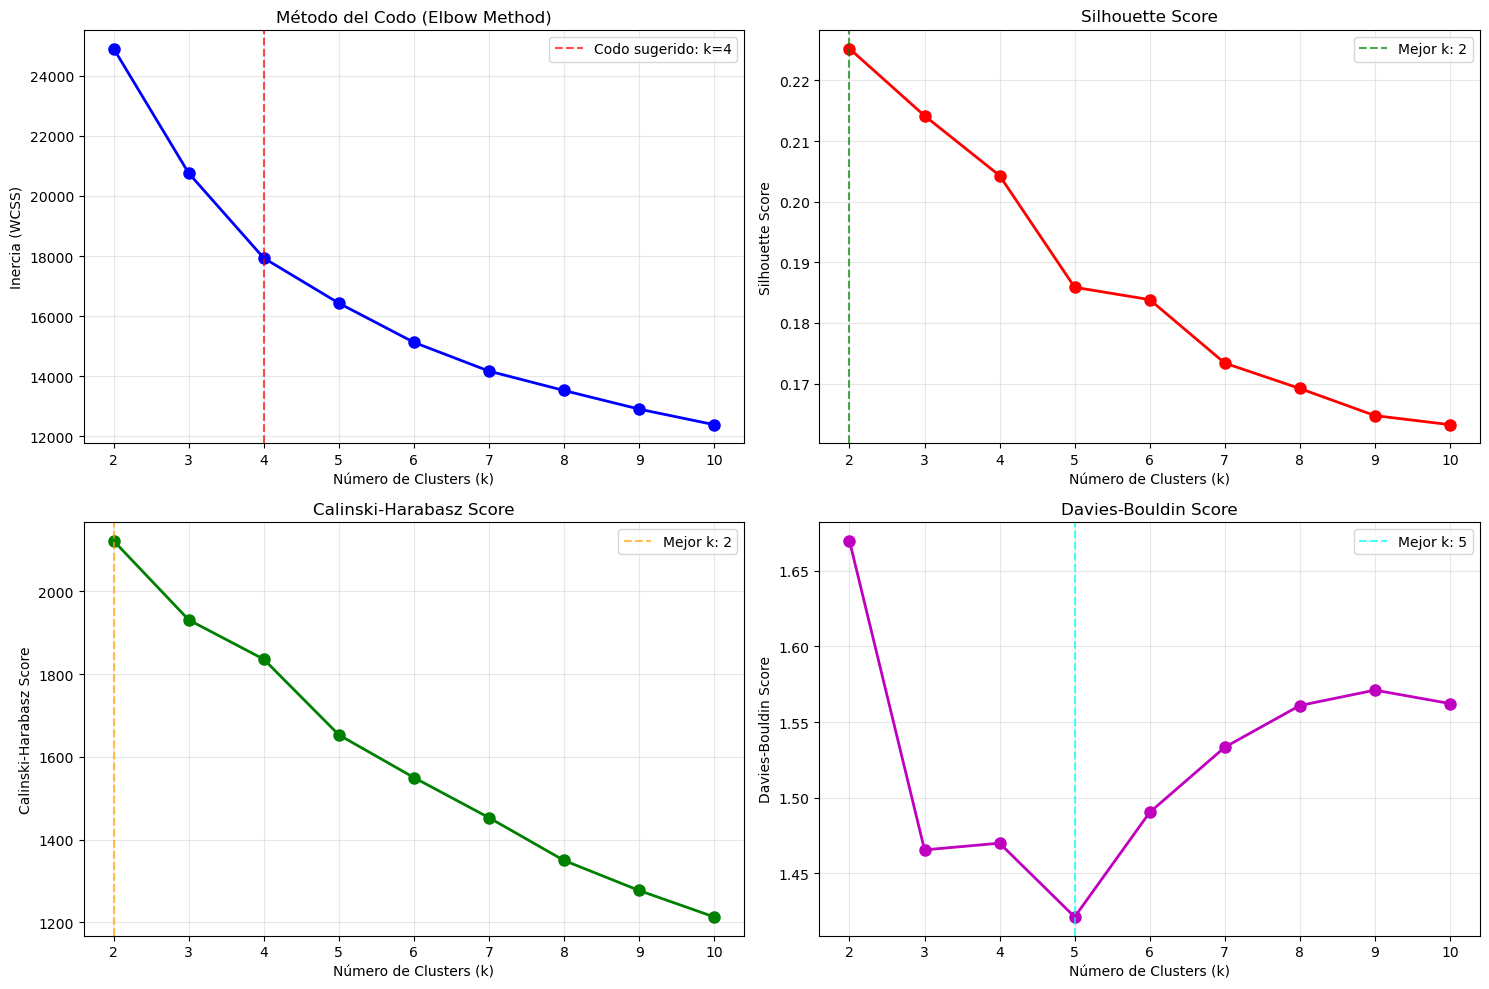


 Recomendaciones para n√∫mero de clusters:
   ‚Ä¢ M√©todo del codo: k = 4
   ‚Ä¢ Mejor Silhouette Score: k = 2 (Score: 0.225)
   ‚Ä¢ Mejor Calinski-Harabasz: k = 2 (Score: 2122.2)
   ‚Ä¢ Mejor Davies-Bouldin: k = 5 (Score: 1.421)

 N√∫mero √≥ptimo de clusters seleccionado: k = 2


In [28]:
print("DETERMINACI√ìN DEL N√öMERO √ìPTIMO DE CLUSTERS")
print("="*60)

# M√©todo del codo (Elbow Method) y Silhouette Score
k_range = range(2, 11)  # Evaluar de 2 a 10 clusters
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("üîÑ Evaluando diferentes n√∫meros de clusters...")

for k in k_range:
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # M√©tricas de evaluaci√≥n
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, cluster_labels))
    
    print(f"   K={k}: Silhouette={silhouette_scores[-1]:.3f}, "
          f"Calinski-Harabasz={calinski_scores[-1]:.1f}, "
          f"Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")

# Gr√°fico 2: M√©tricas para selecci√≥n de clusters
plt.figure(figsize=(15, 10))

# M√©todo del codo
plt.subplot(2, 2, 1)
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('M√©todo del Codo (Elbow Method)')
plt.xlabel('N√∫mero de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.grid(True, alpha=0.3)

# Encontrar el "codo" (punto de mayor curvatura)
differences = np.diff(inertias)
second_differences = np.diff(differences)
elbow_point = k_range[np.argmax(second_differences) + 1]
plt.axvline(elbow_point, color='red', linestyle='--', alpha=0.7, 
           label=f'Codo sugerido: k={elbow_point}')
plt.legend()

# Silhouette Score
plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.title('Silhouette Score')
plt.xlabel('N√∫mero de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)

# Marcar el mejor silhouette score
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
plt.axvline(best_k_silhouette, color='green', linestyle='--', alpha=0.7,
           label=f'Mejor k: {best_k_silhouette}')
plt.legend()

# Calinski-Harabasz Score
plt.subplot(2, 2, 3)
plt.plot(k_range, calinski_scores, 'go-', linewidth=2, markersize=8)
plt.title('Calinski-Harabasz Score')
plt.xlabel('N√∫mero de Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True, alpha=0.3)

best_k_calinski = k_range[np.argmax(calinski_scores)]
plt.axvline(best_k_calinski, color='orange', linestyle='--', alpha=0.7,
           label=f'Mejor k: {best_k_calinski}')
plt.legend()

# Davies-Bouldin Score (menor es mejor)
plt.subplot(2, 2, 4)
plt.plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
plt.title('Davies-Bouldin Score')
plt.xlabel('N√∫mero de Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True, alpha=0.3)

best_k_davies = k_range[np.argmin(davies_bouldin_scores)]
plt.axvline(best_k_davies, color='cyan', linestyle='--', alpha=0.7,
           label=f'Mejor k: {best_k_davies}')
plt.legend()

plt.tight_layout()
plt.show()

# Determinar el n√∫mero √≥ptimo de clusters
print(f"\n Recomendaciones para n√∫mero de clusters:")
print(f"   ‚Ä¢ M√©todo del codo: k = {elbow_point}")
print(f"   ‚Ä¢ Mejor Silhouette Score: k = {best_k_silhouette} (Score: {max(silhouette_scores):.3f})")
print(f"   ‚Ä¢ Mejor Calinski-Harabasz: k = {best_k_calinski} (Score: {max(calinski_scores):.1f})")
print(f"   ‚Ä¢ Mejor Davies-Bouldin: k = {best_k_davies} (Score: {min(davies_bouldin_scores):.3f})")

# Seleccionar k √≥ptimo (mayor√≠a de votos o Silhouette como criterio principal)
k_optimal = best_k_silhouette
print(f"\n N√∫mero √≥ptimo de clusters seleccionado: k = {k_optimal}")


### 6. APLICACI√ìN DE ALGORITMOS DE CLUSTERING

In [31]:
print("APLICACI√ìN DE ALGORITMOS DE CLUSTERING")
print("="*60)

# 1. K-Means Clustering
print(" Aplicando K-Means Clustering...")
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)

# 2. Hierarchical Clustering (Agglomerative)
print(" Aplicando Hierarchical Clustering...")
hierarchical = AgglomerativeClustering(n_clusters=k_optimal)
clusters_hierarchical = hierarchical.fit_predict(X_scaled)

# 3. DBSCAN (para comparaci√≥n)
print(" Aplicando DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)

# Agregar los clusters al DataFrame original
df_estres_clustered = df_estres.copy()
df_estres_clustered['Cluster_KMeans'] = clusters_kmeans
df_estres_clustered['Cluster_Hierarchical'] = clusters_hierarchical
df_estres_clustered['Cluster_DBSCAN'] = clusters_dbscan

# Evaluar calidad de clustering
print(f"\n Evaluaci√≥n de algoritmos de clustering:")

# K-Means
silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)
calinski_kmeans = calinski_harabasz_score(X_scaled, clusters_kmeans)
davies_kmeans = davies_bouldin_score(X_scaled, clusters_kmeans)

print(f"   K-Means:")
print(f"      ‚Ä¢ Silhouette Score: {silhouette_kmeans:.3f}")
print(f"      ‚Ä¢ Calinski-Harabasz: {calinski_kmeans:.1f}")
print(f"      ‚Ä¢ Davies-Bouldin: {davies_kmeans:.3f}")
print(f"      ‚Ä¢ Clusters formados: {len(np.unique(clusters_kmeans))}")

# Hierarchical
silhouette_hier = silhouette_score(X_scaled, clusters_hierarchical)
calinski_hier = calinski_harabasz_score(X_scaled, clusters_hierarchical)
davies_hier = davies_bouldin_score(X_scaled, clusters_hierarchical)

print(f"   Hierarchical:")
print(f"      ‚Ä¢ Silhouette Score: {silhouette_hier:.3f}")
print(f"      ‚Ä¢ Calinski-Harabasz: {calinski_hier:.1f}")
print(f"      ‚Ä¢ Davies-Bouldin: {davies_hier:.3f}")
print(f"      ‚Ä¢ Clusters formados: {len(np.unique(clusters_hierarchical))}")

# DBSCAN
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

if n_clusters_dbscan > 1:
    # Solo calcular m√©tricas si hay m√°s de 1 cluster
    silhouette_dbscan = silhouette_score(X_scaled, clusters_dbscan)
    print(f"   DBSCAN:")
    print(f"      ‚Ä¢ Silhouette Score: {silhouette_dbscan:.3f}")
    print(f"      ‚Ä¢ Clusters formados: {n_clusters_dbscan}")
    print(f"      ‚Ä¢ Puntos de ruido: {n_noise}")
else:
    print(f"   DBSCAN:")
    print(f"      ‚Ä¢ Clusters formados: {n_clusters_dbscan}")
    print(f"      ‚Ä¢ Puntos de ruido: {n_noise}")
    print(f"      ‚Ä¢ ‚ö†Ô∏è  DBSCAN no encontr√≥ clusters v√°lidos")

# Seleccionar mejor algoritmo
mejor_algoritmo = "K-Means"  # Por simplicidad y interpretabilidad
clusters_finales = clusters_kmeans

print(f"\n Algoritmo seleccionado: {mejor_algoritmo}")


APLICACI√ìN DE ALGORITMOS DE CLUSTERING
 Aplicando K-Means Clustering...
 Aplicando Hierarchical Clustering...
 Aplicando DBSCAN...

 Evaluaci√≥n de algoritmos de clustering:
   K-Means:
      ‚Ä¢ Silhouette Score: 0.225
      ‚Ä¢ Calinski-Harabasz: 2122.2
      ‚Ä¢ Davies-Bouldin: 1.670
      ‚Ä¢ Clusters formados: 2
   Hierarchical:
      ‚Ä¢ Silhouette Score: 0.190
      ‚Ä¢ Calinski-Harabasz: 1585.2
      ‚Ä¢ Davies-Bouldin: 1.809
      ‚Ä¢ Clusters formados: 2
   DBSCAN:
      ‚Ä¢ Silhouette Score: -0.521
      ‚Ä¢ Clusters formados: 67
      ‚Ä¢ Puntos de ruido: 3247

 Algoritmo seleccionado: K-Means


### 7. AN√ÅLISIS Y CARACTERIZACI√ìN DE CLUSTERS

AN√ÅLISIS Y CARACTERIZACI√ìN DE CLUSTERS
 Estad√≠sticas descriptivas por cluster:

   üî∏ CLUSTER 0:
      ‚Ä¢ N√∫mero de pacientes: 2919
      ‚Ä¢ Porcentaje del total: 44.3%
      ‚Ä¢ Nivel_estres: 8.0 ¬± 1.8
      ‚Ä¢ Frecuencia_cardiaca: 80.2 ¬± 12.7
      ‚Ä¢ Presion_sistolica: 119.2 ¬± 15.6
      ‚Ä¢ Variabilidad_ritmo: 29.1 ¬± 9.4
      ‚Ä¢ Temperatura: 36.8 ¬± 0.5

   üî∏ CLUSTER 1:
      ‚Ä¢ N√∫mero de pacientes: 3668
      ‚Ä¢ Porcentaje del total: 55.7%
      ‚Ä¢ Nivel_estres: 6.4 ¬± 2.4
      ‚Ä¢ Frecuencia_cardiaca: 60.1 ¬± 8.7
      ‚Ä¢ Presion_sistolica: 105.9 ¬± 11.2
      ‚Ä¢ Variabilidad_ritmo: 37.6 ¬± 9.7
      ‚Ä¢ Temperatura: 36.3 ¬± 0.4

 Generando visualizaciones de clusters...


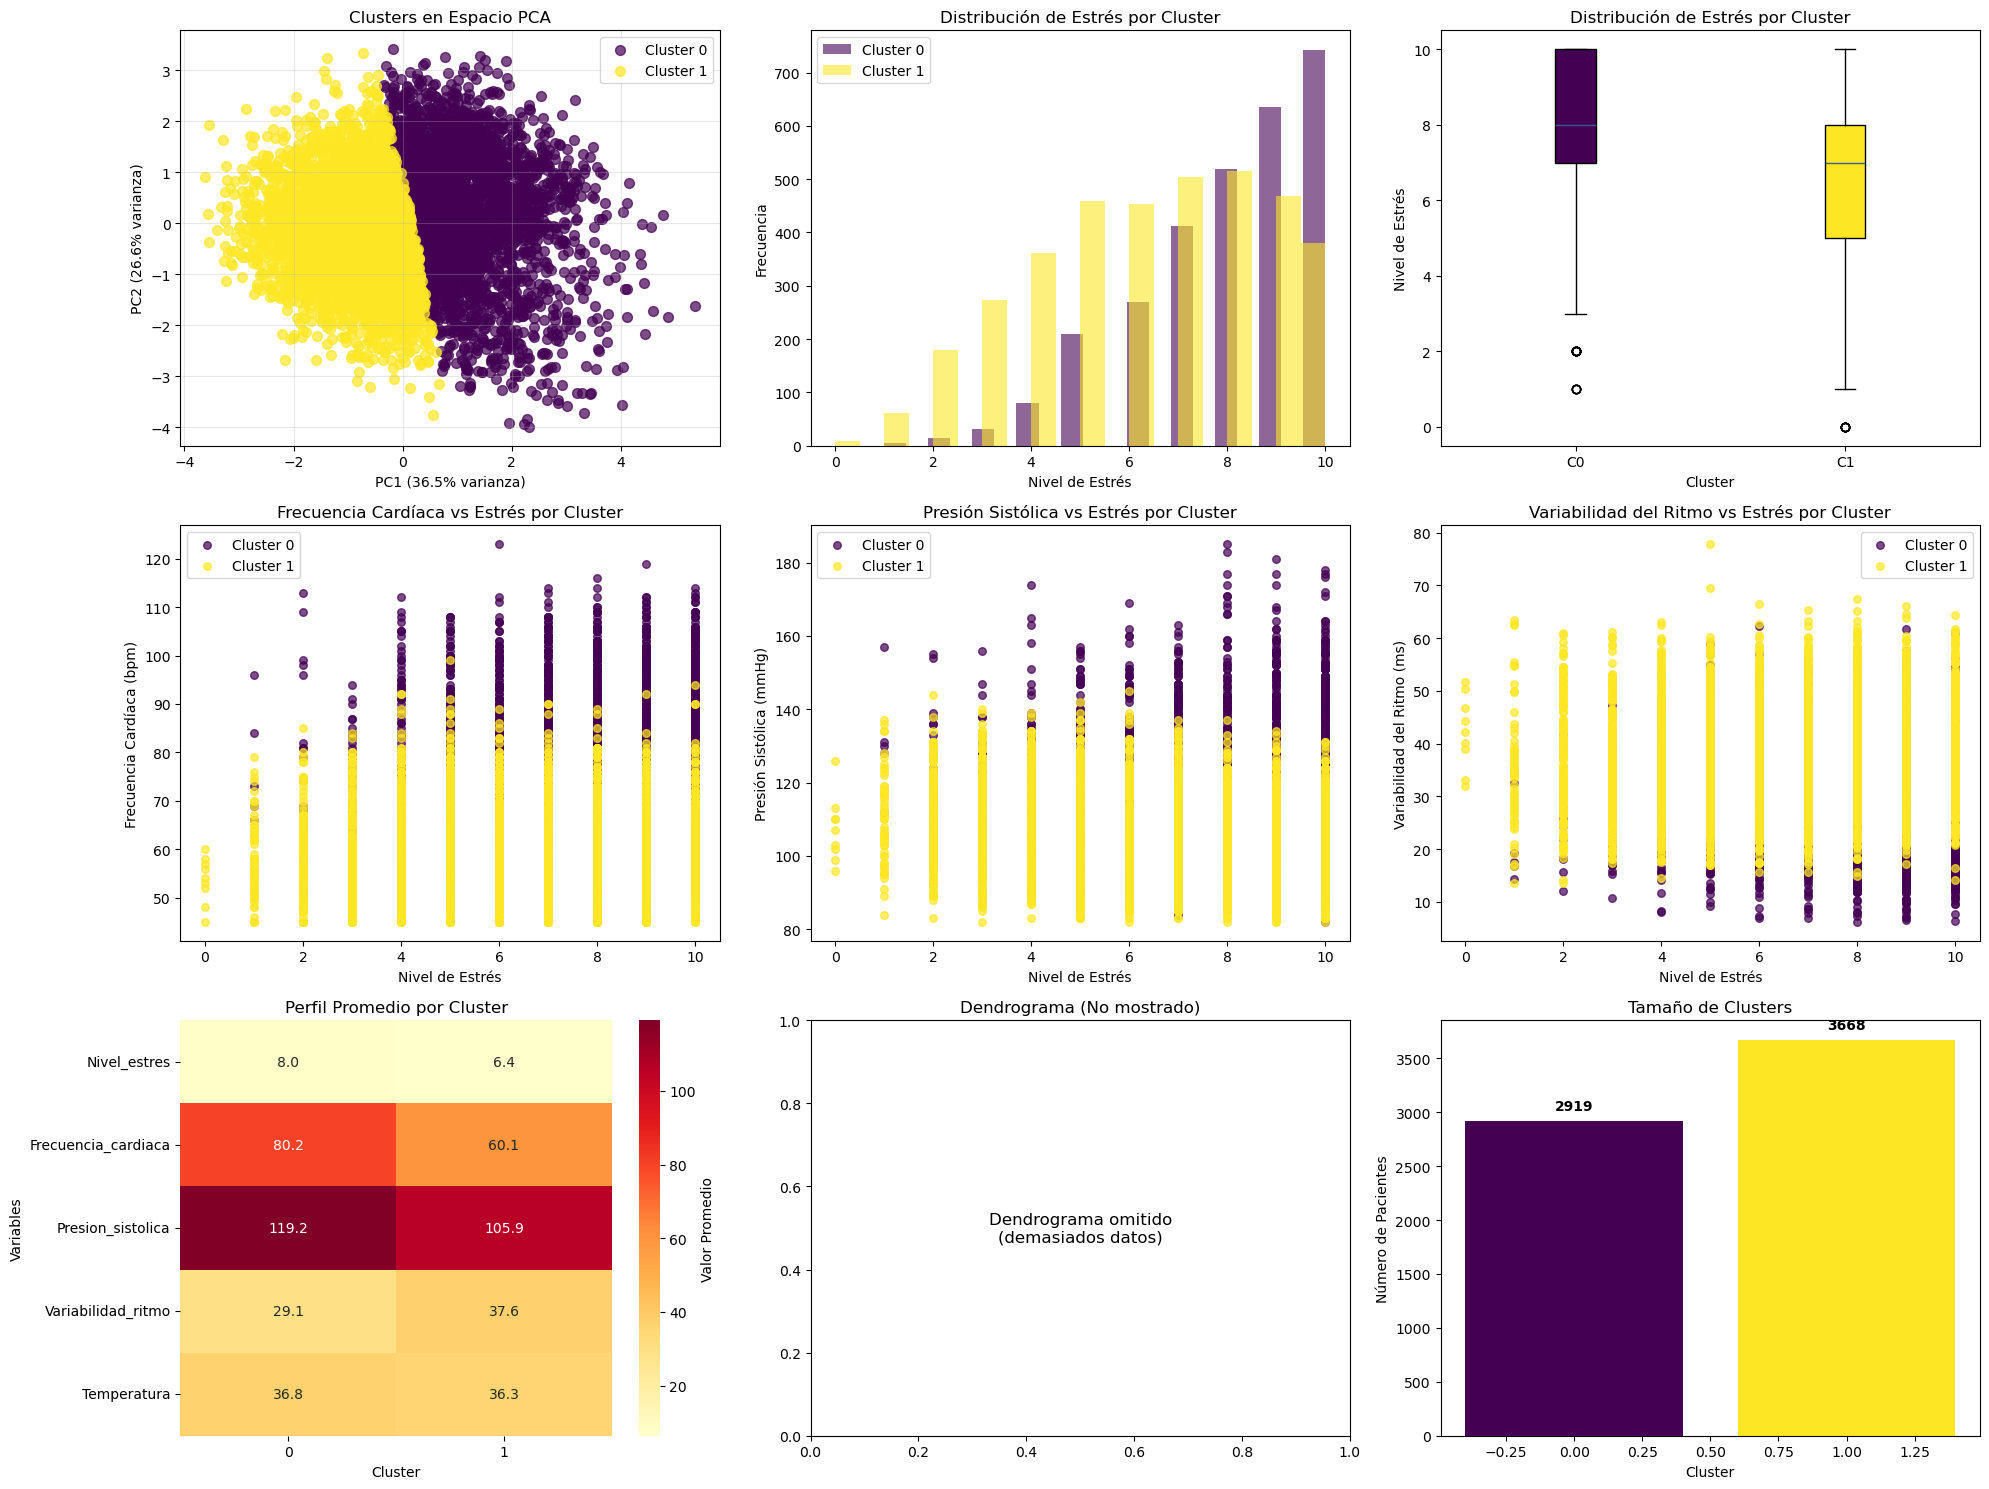

In [34]:
print("AN√ÅLISIS Y CARACTERIZACI√ìN DE CLUSTERS")
print("="*60)

# Agregar cluster final al DataFrame
df_estres_clustered['Cluster_Final'] = clusters_finales

# Estad√≠sticas por cluster
print(" Estad√≠sticas descriptivas por cluster:")
cluster_stats = df_estres_clustered.groupby('Cluster_Final')[variables_estres].agg(['mean', 'std', 'count'])

for cluster in sorted(df_estres_clustered['Cluster_Final'].unique()):
    print(f"\n   üî∏ CLUSTER {cluster}:")
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == cluster]
    print(f"      ‚Ä¢ N√∫mero de pacientes: {len(cluster_data)}")
    print(f"      ‚Ä¢ Porcentaje del total: {len(cluster_data)/len(df_estres_clustered)*100:.1f}%")
    
    for var in variables_estres:
        mean_val = cluster_data[var].mean()
        std_val = cluster_data[var].std()
        print(f"      ‚Ä¢ {var}: {mean_val:.1f} ¬± {std_val:.1f}")

# Gr√°fico 3: Visualizaci√≥n de clusters en 2D usando PCA
print("\n Generando visualizaciones de clusters...")

plt.figure(figsize=(20, 15))

# PCA para reducir dimensionalidad a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Colores para clusters
colors = plt.cm.viridis(np.linspace(0, 1, k_optimal))

# Subplot 1: Clusters en espacio PCA
plt.subplot(3, 3, 1)
for i in range(k_optimal):
    mask = clusters_finales == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]], 
               label=f'Cluster {i}', alpha=0.7, s=50)

plt.title('Clusters en Espacio PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Distribuci√≥n de clusters por nivel de estr√©s
plt.subplot(3, 3, 2)
for i in range(k_optimal):
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == i]
    plt.hist(cluster_data['Nivel_estres'], bins=20, alpha=0.6, 
            label=f'Cluster {i}', color=colors[i])

plt.title('Distribuci√≥n de Estr√©s por Cluster')
plt.xlabel('Nivel de Estr√©s')
plt.ylabel('Frecuencia')
plt.legend()

# Subplot 3: Boxplot de nivel de estr√©s por cluster
plt.subplot(3, 3, 3)
stress_by_cluster = [df_estres_clustered[df_estres_clustered['Cluster_Final'] == i]['Nivel_estres'].values 
                    for i in range(k_optimal)]
box_plot = plt.boxplot(stress_by_cluster, patch_artist=True, labels=[f'C{i}' for i in range(k_optimal)])

for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribuci√≥n de Estr√©s por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Nivel de Estr√©s')

# Subplot 4: Frecuencia card√≠aca vs Nivel de estr√©s por cluster
plt.subplot(3, 3, 4)
for i in range(k_optimal):
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == i]
    plt.scatter(cluster_data['Nivel_estres'], cluster_data['Frecuencia_cardiaca'], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=30)

plt.title('Frecuencia Card√≠aca vs Estr√©s por Cluster')
plt.xlabel('Nivel de Estr√©s')
plt.ylabel('Frecuencia Card√≠aca (bpm)')
plt.legend()

# Subplot 5: Presi√≥n sist√≥lica vs Nivel de estr√©s por cluster
plt.subplot(3, 3, 5)
for i in range(k_optimal):
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == i]
    plt.scatter(cluster_data['Nivel_estres'], cluster_data['Presion_sistolica'], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=30)

plt.title('Presi√≥n Sist√≥lica vs Estr√©s por Cluster')
plt.xlabel('Nivel de Estr√©s')
plt.ylabel('Presi√≥n Sist√≥lica (mmHg)')
plt.legend()

# Subplot 6: Variabilidad del ritmo vs Nivel de estr√©s por cluster
plt.subplot(3, 3, 6)
for i in range(k_optimal):
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == i]
    plt.scatter(cluster_data['Nivel_estres'], cluster_data['Variabilidad_ritmo'], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=30)

plt.title('Variabilidad del Ritmo vs Estr√©s por Cluster')
plt.xlabel('Nivel de Estr√©s')
plt.ylabel('Variabilidad del Ritmo (ms)')
plt.legend()

# Subplot 7: Heatmap de medias por cluster
plt.subplot(3, 3, 7)
cluster_means = df_estres_clustered.groupby('Cluster_Final')[variables_estres].mean()
sns.heatmap(cluster_means.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Valor Promedio'})
plt.title('Perfil Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Variables')

# Subplot 8: Dendrograma (si hay pocos puntos)
plt.subplot(3, 3, 8)
if len(df_estres) <= 1000:  # Solo si hay pocos datos para que sea legible
    # Calcular linkage para dendrograma
    linkage_matrix = linkage(X_scaled, method='ward')
    dendrogram(linkage_matrix, truncate_mode='level', p=3)
    plt.title('Dendrograma (Hierarchical Clustering)')
    plt.xlabel('Muestras')
    plt.ylabel('Distancia')
else:
    plt.text(0.5, 0.5, 'Dendrograma omitido\n(demasiados datos)', 
            ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Dendrograma (No mostrado)')

# Subplot 9: Distribuci√≥n de tama√±os de cluster
plt.subplot(3, 3, 9)
cluster_sizes = df_estres_clustered['Cluster_Final'].value_counts().sort_index()
bars = plt.bar(range(k_optimal), cluster_sizes.values, color=colors)
plt.title('Tama√±o de Clusters')
plt.xlabel('Cluster')
plt.ylabel('N√∫mero de Pacientes')

# Agregar etiquetas en las barras
for bar, size in zip(bars, cluster_sizes.values):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(cluster_sizes)*0.02, 
             str(size), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### 8. INTERPRETACI√ìN M√âDICA DE LOS CLUSTERS

In [37]:
print("INTERPRETACI√ìN M√âDICA DE LOS CLUSTERS")
print("="*60)

# Definir nombres interpretativos para cada cluster
cluster_interpretations = {}

for cluster in sorted(df_estres_clustered['Cluster_Final'].unique()):
    cluster_data = df_estres_clustered[df_estres_clustered['Cluster_Final'] == cluster]
    
    # Analizar caracter√≠sticas del cluster
    avg_stress = cluster_data['Nivel_estres'].mean()
    avg_hr = cluster_data['Frecuencia_cardiaca'].mean()
    avg_bp = cluster_data['Presion_sistolica'].mean()
    avg_hrv = cluster_data['Variabilidad_ritmo'].mean()
    avg_temp = cluster_data['Temperatura'].mean()
    
    # Clasificar el tipo de estr√©s basado en los promedios
    if avg_stress < 25:
        stress_level = "Bajo Estr√©s"
        risk_level = "Riesgo M√≠nimo"
        color_code = "üü¢"
    elif avg_stress < 50:
        stress_level = "Estr√©s Moderado"
        risk_level = "Riesgo Bajo-Moderado"
        color_code = "üü°"
    elif avg_stress < 75:
        stress_level = "Alto Estr√©s"
        risk_level = "Riesgo Alto"
        color_code = "üü†"
    else:
        stress_level = "Estr√©s Severo"
        risk_level = "Riesgo Cr√≠tico"
        color_code = "üî¥"
    
    # Analizar respuesta fisiol√≥gica
    if avg_hr > 90:
        hr_response = "Taquicardia de estr√©s"
    elif avg_hr > 80:
        hr_response = "FC ligeramente elevada"
    else:
        hr_response = "FC normal"
    
    if avg_bp > 140:
        bp_response = "Hipertensi√≥n por estr√©s"
    elif avg_bp > 130:
        bp_response = "Presi√≥n elevada"
    else:
        bp_response = "Presi√≥n normal"
    
    if avg_hrv < 30:
        hrv_response = "Variabilidad reducida (estr√©s alto)"
    elif avg_hrv < 40:
        hrv_response = "Variabilidad moderada"
    else:
        hrv_response = "Variabilidad saludable"
    
    # Generar interpretaci√≥n
    interpretation = {
        'nombre': f"{color_code} {stress_level}",
        'n_pacientes': len(cluster_data),
        'porcentaje': len(cluster_data)/len(df_estres_clustered)*100,
        'caracteristicas': {
            'nivel_estres': avg_stress,
            'frecuencia_cardiaca': avg_hr,
            'presion_sistolica': avg_bp,
            'variabilidad_ritmo': avg_hrv,
            'temperatura': avg_temp
        },
        'respuesta_fisiologica': {
            'cardiaca': hr_response,
            'presion': bp_response,
            'autonoma': hrv_response
        },
        'riesgo': risk_level,
        'recomendaciones': []
    }
    
    # Generar recomendaciones espec√≠ficas
    if avg_stress < 25:
        interpretation['recomendaciones'] = [
            "Mantener h√°bitos saludables actuales",
            "Monitoreo preventivo regular",
            "Ejercicio moderado regular"
        ]
    elif avg_stress < 50:
        interpretation['recomendaciones'] = [
            "T√©cnicas de relajaci√≥n y mindfulness",
            "Evaluaci√≥n de factores estresantes",
            "Ejercicio aer√≥bico regular"
        ]
    elif avg_stress < 75:
        interpretation['recomendaciones'] = [
            "Intervenci√≥n psicol√≥gica especializada",
            "T√©cnicas de manejo de estr√©s avanzadas",
            "Evaluaci√≥n m√©dica cardiovascular",
            "Posible medicaci√≥n ansiol√≠tica"
        ]
    else:
        interpretation['recomendaciones'] = [
            "Atenci√≥n m√©dica inmediata",
            "Evaluaci√≥n psiqui√°trica",
            "Monitoreo cardiovascular continuo",
            "Intervenci√≥n farmacol√≥gica",
            "Terapia intensiva de manejo de estr√©s"
        ]
    
    cluster_interpretations[cluster] = interpretation

# Mostrar interpretaciones
print("üîç Interpretaci√≥n m√©dica de cada cluster:")
for cluster, interp in cluster_interpretations.items():
    print(f"\n{interp['nombre']} (Cluster {cluster}):")
    print(f"    Pacientes: {interp['n_pacientes']} ({interp['porcentaje']:.1f}%)")
    print(f"    Caracter√≠sticas promedio:")
    print(f"      ‚Ä¢ Nivel de estr√©s: {interp['caracteristicas']['nivel_estres']:.1f}")
    print(f"      ‚Ä¢ Frecuencia card√≠aca: {interp['caracteristicas']['frecuencia_cardiaca']:.1f} bpm")
    print(f"      ‚Ä¢ Presi√≥n sist√≥lica: {interp['caracteristicas']['presion_sistolica']:.1f} mmHg")
    print(f"      ‚Ä¢ Variabilidad del ritmo: {interp['caracteristicas']['variabilidad_ritmo']:.1f} ms")
    print(f"      ‚Ä¢ Temperatura: {interp['caracteristicas']['temperatura']:.1f}¬∞C")
    
    print(f"    Respuesta fisiol√≥gica:")
    print(f"      ‚Ä¢ Card√≠aca: {interp['respuesta_fisiologica']['cardiaca']}")
    print(f"      ‚Ä¢ Presi√≥n arterial: {interp['respuesta_fisiologica']['presion']}")
    print(f"      ‚Ä¢ Sistema aut√≥nomo: {interp['respuesta_fisiologica']['autonoma']}")
    
    print(f"   ‚ö†Ô∏è  Nivel de riesgo: {interp['riesgo']}")
    print(f"    Recomendaciones:")
    for rec in interp['recomendaciones']:
        print(f"      ‚Ä¢ {rec}")

INTERPRETACI√ìN M√âDICA DE LOS CLUSTERS
üîç Interpretaci√≥n m√©dica de cada cluster:

üü¢ Bajo Estr√©s (Cluster 0):
    Pacientes: 2919 (44.3%)
    Caracter√≠sticas promedio:
      ‚Ä¢ Nivel de estr√©s: 8.0
      ‚Ä¢ Frecuencia card√≠aca: 80.2 bpm
      ‚Ä¢ Presi√≥n sist√≥lica: 119.2 mmHg
      ‚Ä¢ Variabilidad del ritmo: 29.1 ms
      ‚Ä¢ Temperatura: 36.8¬∞C
    Respuesta fisiol√≥gica:
      ‚Ä¢ Card√≠aca: FC ligeramente elevada
      ‚Ä¢ Presi√≥n arterial: Presi√≥n normal
      ‚Ä¢ Sistema aut√≥nomo: Variabilidad reducida (estr√©s alto)
   ‚ö†Ô∏è  Nivel de riesgo: Riesgo M√≠nimo
    Recomendaciones:
      ‚Ä¢ Mantener h√°bitos saludables actuales
      ‚Ä¢ Monitoreo preventivo regular
      ‚Ä¢ Ejercicio moderado regular

üü¢ Bajo Estr√©s (Cluster 1):
    Pacientes: 3668 (55.7%)
    Caracter√≠sticas promedio:
      ‚Ä¢ Nivel de estr√©s: 6.4
      ‚Ä¢ Frecuencia card√≠aca: 60.1 bpm
      ‚Ä¢ Presi√≥n sist√≥lica: 105.9 mmHg
      ‚Ä¢ Variabilidad del ritmo: 37.6 ms
      ‚Ä¢ Temper

### 9. FUNCI√ìN PARA CLASIFICAR NUEVOS PACIENTES

In [40]:
print("FUNCI√ìN DE CLASIFICACI√ìN PARA NUEVOS PACIENTES")
print("="*60)

def clasificar_patron_estres(nivel_estres, frecuencia_cardiaca, presion_sistolica, 
                           variabilidad_ritmo, temperatura):
    """
    Clasifica a un nuevo paciente en uno de los patrones de estr√©s identificados
    
    Args:
        nivel_estres (float): Nivel de estr√©s (0-100)
        frecuencia_cardiaca (float): Frecuencia card√≠aca en bpm
        presion_sistolica (float): Presi√≥n sist√≥lica en mmHg
        variabilidad_ritmo (float): Variabilidad del ritmo en ms
        temperatura (float): Temperatura corporal en ¬∞C
    
    Returns:
        dict: Informaci√≥n del cluster y recomendaciones
    """
    
    # Crear array con los nuevos datos
    nuevos_datos = np.array([[nivel_estres, frecuencia_cardiaca, presion_sistolica, 
                             variabilidad_ritmo, temperatura]])
    
    # Normalizar usando el mismo scaler
    nuevos_datos_scaled = scaler.transform(nuevos_datos)
    
    # Predecir cluster
    cluster_predicho = kmeans.predict(nuevos_datos_scaled)[0]
    
    # Obtener interpretaci√≥n del cluster
    interpretacion = cluster_interpretations[cluster_predicho]
    
    # Calcular distancia a centroide del cluster
    centroide = kmeans.cluster_centers_[cluster_predicho]
    distancia = np.linalg.norm(nuevos_datos_scaled[0] - centroide)
    
    # Calcular confianza (mayor distancia = menor confianza)
    confianza = max(0, 1 - (distancia / 2))  # Normalizar aproximadamente entre 0 y 1
    
    return {
        'cluster': cluster_predicho,
        'nombre_cluster': interpretacion['nombre'],
        'confianza': confianza,
        'caracteristicas_cluster': interpretacion['caracteristicas'],
        'riesgo': interpretacion['riesgo'],
        'recomendaciones': interpretacion['recomendaciones'],
        'distancia_centroide': distancia
    }


FUNCI√ìN DE CLASIFICACI√ìN PARA NUEVOS PACIENTES


### 10. EJEMPLOS DE CLASIFICACI√ìN

In [43]:
print("\n Ejemplos de clasificaci√≥n de nuevos pacientes:")

# Ejemplo 1: Paciente con bajo estr√©s
ejemplo_bajo_estres = {
    'nivel_estres': 15,
    'frecuencia_cardiaca': 72,
    'presion_sistolica': 115,
    'variabilidad_ritmo': 45,
    'temperatura': 36.6
}

resultado_bajo = clasificar_patron_estres(**ejemplo_bajo_estres)

print(f"\n Ejemplo 1 - Paciente con signos de bajo estr√©s:")
print(f"   Datos de entrada:")
for key, value in ejemplo_bajo_estres.items():
    print(f"      ‚Ä¢ {key}: {value}")

print(f"\n    Resultado de clasificaci√≥n:")
print(f"      ‚Ä¢ Cluster: {resultado_bajo['cluster']}")
print(f"      ‚Ä¢ Patr√≥n: {resultado_bajo['nombre_cluster']}")
print(f"      ‚Ä¢ Confianza: {resultado_bajo['confianza']:.2f}")
print(f"      ‚Ä¢ Riesgo: {resultado_bajo['riesgo']}")
print(f"      ‚Ä¢ Recomendaciones principales:")
for rec in resultado_bajo['recomendaciones'][:2]:
    print(f"         - {rec}")

# Ejemplo 2: Paciente con alto estr√©s
ejemplo_alto_estres = {
    'nivel_estres': 85,
    'frecuencia_cardiaca': 105,
    'presion_sistolica': 155,
    'variabilidad_ritmo': 22,
    'temperatura': 37.3
}

resultado_alto = clasificar_patron_estres(**ejemplo_alto_estres)

print(f"\n Ejemplo 2 - Paciente con signos de alto estr√©s:")
print(f"   Datos de entrada:")
for key, value in ejemplo_alto_estres.items():
    print(f"      ‚Ä¢ {key}: {value}")

print(f"\n    Resultado de clasificaci√≥n:")
print(f"      ‚Ä¢ Cluster: {resultado_alto['cluster']}")
print(f"      ‚Ä¢ Patr√≥n: {resultado_alto['nombre_cluster']}")
print(f"      ‚Ä¢ Confianza: {resultado_alto['confianza']:.2f}")
print(f"      ‚Ä¢ Riesgo: {resultado_alto['riesgo']}")
print(f"      ‚Ä¢ Recomendaciones principales:")
for rec in resultado_alto['recomendaciones'][:3]:
    print(f"         - {rec}")


 Ejemplos de clasificaci√≥n de nuevos pacientes:

 Ejemplo 1 - Paciente con signos de bajo estr√©s:
   Datos de entrada:
      ‚Ä¢ nivel_estres: 15
      ‚Ä¢ frecuencia_cardiaca: 72
      ‚Ä¢ presion_sistolica: 115
      ‚Ä¢ variabilidad_ritmo: 45
      ‚Ä¢ temperatura: 36.6

    Resultado de clasificaci√≥n:
      ‚Ä¢ Cluster: 0
      ‚Ä¢ Patr√≥n: üü¢ Bajo Estr√©s
      ‚Ä¢ Confianza: 0.00
      ‚Ä¢ Riesgo: Riesgo M√≠nimo
      ‚Ä¢ Recomendaciones principales:
         - Mantener h√°bitos saludables actuales
         - Monitoreo preventivo regular

 Ejemplo 2 - Paciente con signos de alto estr√©s:
   Datos de entrada:
      ‚Ä¢ nivel_estres: 85
      ‚Ä¢ frecuencia_cardiaca: 105
      ‚Ä¢ presion_sistolica: 155
      ‚Ä¢ variabilidad_ritmo: 22
      ‚Ä¢ temperatura: 37.3

    Resultado de clasificaci√≥n:
      ‚Ä¢ Cluster: 0
      ‚Ä¢ Patr√≥n: üü¢ Bajo Estr√©s
      ‚Ä¢ Confianza: 0.00
      ‚Ä¢ Riesgo: Riesgo M√≠nimo
      ‚Ä¢ Recomendaciones principales:
         - Mantener h√°bit

### 11. RESUMEN Y CONCLUSIONES

In [46]:
print("RESUMEN Y CONCLUSIONES DEL AN√ÅLISIS NO SUPERVISADO")
print("="*60)

print("‚úÖ An√°lisis completado exitosamente")
print(f" Resumen del modelo:")
print(f"   ‚Ä¢ Algoritmo seleccionado: K-Means")
print(f"   ‚Ä¢ N√∫mero de clusters √≥ptimo: {k_optimal}")
print(f"   ‚Ä¢ Silhouette Score: {silhouette_kmeans:.3f}")
print(f"   ‚Ä¢ Variables analizadas: {len(variables_estres)}")
print(f"   ‚Ä¢ Muestras procesadas: {len(df_estres)}")

print(f"\n Patrones de estr√©s identificados:")
for cluster, interp in cluster_interpretations.items():
    print(f"   ‚Ä¢ {interp['nombre']}: {interp['n_pacientes']} pacientes ({interp['porcentaje']:.1f}%)")

print(f"\n Insights principales:")
correlations = []
for var in variables_estres[1:]:
    corr = df_estres['Nivel_estres'].corr(df_estres[var])
    correlations.append((var, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"   ‚Ä¢ Variables m√°s correlacionadas con el estr√©s:")
for var, corr in correlations[:3]:
    direction = "positiva" if corr > 0 else "negativa"
    print(f"      - {var}: {corr:.3f} (correlaci√≥n {direction})")

print(f"\n Aplicaciones cl√≠nicas:")
print(f"   ‚Ä¢ Identificaci√≥n autom√°tica de patrones de estr√©s")
print(f"   ‚Ä¢ Clasificaci√≥n de pacientes para tratamiento personalizado")
print(f"   ‚Ä¢ Monitoreo continuo de poblaciones en riesgo")
print(f"   ‚Ä¢ Optimizaci√≥n de recursos de salud mental")

print(f"\n Modelo listo para:")
print(f"   ‚Ä¢ Clasificaci√≥n de nuevos pacientes")
print(f"   ‚Ä¢ Integraci√≥n con sistema de alertas de estr√©s")
print(f"   ‚Ä¢ Monitoreo poblacional de estr√©s")
print(f"   ‚Ä¢ Generaci√≥n de recomendaciones personalizadas")

print("\n" + "="*60)
print("¬°AN√ÅLISIS NO SUPERVISADO DE ESTR√âS COMPLETADO!")
print("="*60)

RESUMEN Y CONCLUSIONES DEL AN√ÅLISIS NO SUPERVISADO
‚úÖ An√°lisis completado exitosamente
 Resumen del modelo:
   ‚Ä¢ Algoritmo seleccionado: K-Means
   ‚Ä¢ N√∫mero de clusters √≥ptimo: 2
   ‚Ä¢ Silhouette Score: 0.225
   ‚Ä¢ Variables analizadas: 5
   ‚Ä¢ Muestras procesadas: 6587

 Patrones de estr√©s identificados:
   ‚Ä¢ üü¢ Bajo Estr√©s: 2919 pacientes (44.3%)
   ‚Ä¢ üü¢ Bajo Estr√©s: 3668 pacientes (55.7%)

 Insights principales:
   ‚Ä¢ Variables m√°s correlacionadas con el estr√©s:
      - Frecuencia_cardiaca: 0.223 (correlaci√≥n positiva)
      - Temperatura: 0.161 (correlaci√≥n positiva)
      - Variabilidad_ritmo: -0.065 (correlaci√≥n negativa)

 Aplicaciones cl√≠nicas:
   ‚Ä¢ Identificaci√≥n autom√°tica de patrones de estr√©s
   ‚Ä¢ Clasificaci√≥n de pacientes para tratamiento personalizado
   ‚Ä¢ Monitoreo continuo de poblaciones en riesgo
   ‚Ä¢ Optimizaci√≥n de recursos de salud mental

 Modelo listo para:
   ‚Ä¢ Clasificaci√≥n de nuevos pacientes
   ‚Ä¢ Integraci√≥n co